<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/ELM/ELM_Trandition_PSO_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# ============================================================
# ELM vs PSO-ELM (Binary Classification)
# Updated with ROC, confusion matrices, bar chart, and convergence
# ============================================================

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# ------------------------------------------------------------
# 1. Data Preparation
# ------------------------------------------------------------
data = pd.read_csv("heart_disease.csv").dropna()
X = data.drop(columns=['Class'])
y = (data['Class'] > 0).astype(int)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------------------------------------
# 2. Activation Function (Sigmoid)
# ------------------------------------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ------------------------------------------------------------
# 3. Traditional ELM Functions
# ------------------------------------------------------------
def train_ELM(X_train, y_train, num_hidden_neurons):
    input_size = X_train.shape[1]
    W = np.random.randn(input_size, num_hidden_neurons)
    b = np.random.randn(num_hidden_neurons)
    H = sigmoid(np.dot(X_train, W) + b)
    beta = np.dot(np.linalg.pinv(H), y_train)
    return W, b, beta

def predict_ELM(X, W, b, beta):
    H = sigmoid(np.dot(X, W) + b)
    y_pred = np.dot(H, beta)
    return y_pred, (y_pred > 0.5).astype(int)

# ------------------------------------------------------------
# 4. PSO-ELM Functions
# ------------------------------------------------------------
def fitness_function(W, b, X, y):
    H = sigmoid(np.dot(X, W) + b)
    beta = np.dot(np.linalg.pinv(H), y)
    y_pred = np.dot(H, beta)
    y_pred_class = (y_pred > 0.5).astype(int)
    # Maximization: return accuracy directly
    return accuracy_score(y, y_pred_class)

def PSO_ELM(X_train, y_train, num_hidden_neurons, pop_size, max_iter):
    input_size = X_train.shape[1]
    dim = input_size * num_hidden_neurons + num_hidden_neurons
    particles = np.random.uniform(-1, 1, (pop_size, dim))
    velocities = np.zeros((pop_size, dim))
    pbest = particles.copy()
    pbest_scores = np.zeros(pop_size)
    gbest = particles[0, :].copy()
    gbest_score = 0
    convergence_curve = []
    w, c1, c2 = 0.7, 1.5, 1.5

    for iteration in range(max_iter):
        for i in range(pop_size):
            W = particles[i, :input_size*num_hidden_neurons].reshape(input_size, num_hidden_neurons)
            b = particles[i, input_size*num_hidden_neurons:]
            score = fitness_function(W, b, X_train, y_train)

            if score > pbest_scores[i]:
                pbest_scores[i] = score
                pbest[i, :] = particles[i, :]

            if score > gbest_score:
                gbest_score = score
                gbest = particles[i, :].copy()

        r1, r2 = np.random.rand(), np.random.rand()
        velocities = (w * velocities +
                      c1 * r1 * (pbest - particles) +
                      c2 * r2 * (gbest - particles))
        particles += velocities
        convergence_curve.append(gbest_score)

    W_best = gbest[:input_size*num_hidden_neurons].reshape(input_size, num_hidden_neurons)
    b_best = gbest[input_size*num_hidden_neurons:]
    H_best = sigmoid(np.dot(X_train, W_best) + b_best)
    beta_best = np.dot(np.linalg.pinv(H_best), y_train)

    return W_best, b_best, beta_best, convergence_curve

# ------------------------------------------------------------
# 5. Run Models and Collect Metrics
# ------------------------------------------------------------
num_hidden_neurons = 20
pop_sizes = [50, 100, 150, 200, 250]
max_iter = 50

results = []
predictions = {}
convergence_curves = {}

# Traditional ELM
W_elm, b_elm, beta_elm = train_ELM(X_train, y_train, num_hidden_neurons)
y_pred_train_prob, y_pred_train = predict_ELM(X_train, W_elm, b_elm, beta_elm)
y_pred_test_prob, y_pred_test = predict_ELM(X_test, W_elm, b_elm, beta_elm)

metrics_train = {
    "Accuracy": accuracy_score(y_train, y_pred_train),
    "Precision": precision_score(y_train, y_pred_train),
    "Recall": recall_score(y_train, y_pred_train),
    "F1": f1_score(y_train, y_pred_train),
    "AUC": roc_auc_score(y_train, y_pred_train_prob)
}

metrics_test = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test),
    "Recall": recall_score(y_test, y_pred_test),
    "F1": f1_score(y_test, y_pred_test),
    "AUC": roc_auc_score(y_test, y_pred_test_prob)
}

results.append(["Traditional ELM", "Train", *metrics_train.values()])
results.append(["Traditional ELM", "Test", *metrics_test.values()])

predictions["Traditional ELM"] = {
    "train": (y_train, y_pred_train, y_pred_train_prob),
    "test": (y_test, y_pred_test, y_pred_test_prob)
}

# PSO-ELM for each population
for pop in pop_sizes:
    W_pso, b_pso, beta_pso, curve = PSO_ELM(X_train, y_train, num_hidden_neurons, pop, max_iter)
    convergence_curves[pop] = curve

    y_pred_train_prob, y_pred_train = predict_ELM(X_train, W_pso, b_pso, beta_pso)
    y_pred_test_prob, y_pred_test = predict_ELM(X_test, W_pso, b_pso, beta_pso)

    metrics_train = {
        "Accuracy": accuracy_score(y_train, y_pred_train),
        "Precision": precision_score(y_train, y_pred_train),
        "Recall": recall_score(y_train, y_pred_train),
        "F1": f1_score(y_train, y_pred_train),
        "AUC": roc_auc_score(y_train, y_pred_train_prob)
    }

    metrics_test = {
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test),
        "Recall": recall_score(y_test, y_pred_test),
        "F1": f1_score(y_test, y_pred_test),
        "AUC": roc_auc_score(y_test, y_pred_test_prob)
    }

    results.append([f"PSO-ELM (pop={pop})", "Train", *metrics_train.values()])
    results.append([f"PSO-ELM (pop={pop})", "Test", *metrics_test.values()])

    predictions[f"PSO-ELM (pop={pop})"] = {
        "train": (y_train, y_pred_train, y_pred_train_prob),
        "test": (y_test, y_pred_test, y_pred_test_prob)
    }

# ------------------------------------------------------------
# 6. Store Results in a DataFrame
# ------------------------------------------------------------
df_results = pd.DataFrame(results, columns=["Model", "Dataset", "Accuracy", "Precision", "Recall", "F1", "AUC"])
df_results


,Model,Dataset,Accuracy,Precision,Recall,F1,AUC
0,Traditional ELM,Train,0.859504,0.866667,0.879699,0.873134,0.927226
1,Traditional ELM,Test,0.868852,0.900000,0.843750,0.870968,0.910560
2,PSO-ELM (pop=50),Train,0.913223,0.905797,0.939850,0.922509,0.935159
3,PSO-ELM (pop=50),Test,0.819672,0.862069,0.781250,0.819672,0.908405
4,PSO-ELM (pop=100),Train,0.913223,0.900000,0.947368,0.923077,0.929572
5,PSO-ELM (pop=100),Test,0.868852,0.875000,0.875000,0.875000,0.936422
6,PSO-ELM (pop=150),Train,0.917355,0.906475,0.947368,0.926471,0.934745
7,PSO-ELM (pop=150),Test,0.868852,0.875000,0.875000,0.875000,0.915948
8,PSO-ELM (pop=200),Train,0.909091,0.899281,0.939850,0.919118,0.940608
9,PSO-ELM (pop=200),Test,0.918033,0.909091,0.937500,0.923077,0.951509


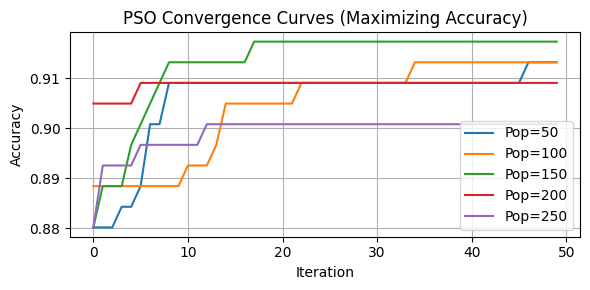

In [27]:
# ------------------------------------------------------------
# 7. Plot PSO Convergence Curves (as maximization)
# ------------------------------------------------------------
plt.figure(figsize=(6,3))
for pop, curve in convergence_curves.items():
    plt.plot(curve, label=f'Pop={pop}')
plt.title("PSO Convergence Curves (Maximizing Accuracy)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("Convergence_all.png", dpi=300)
plt.show()


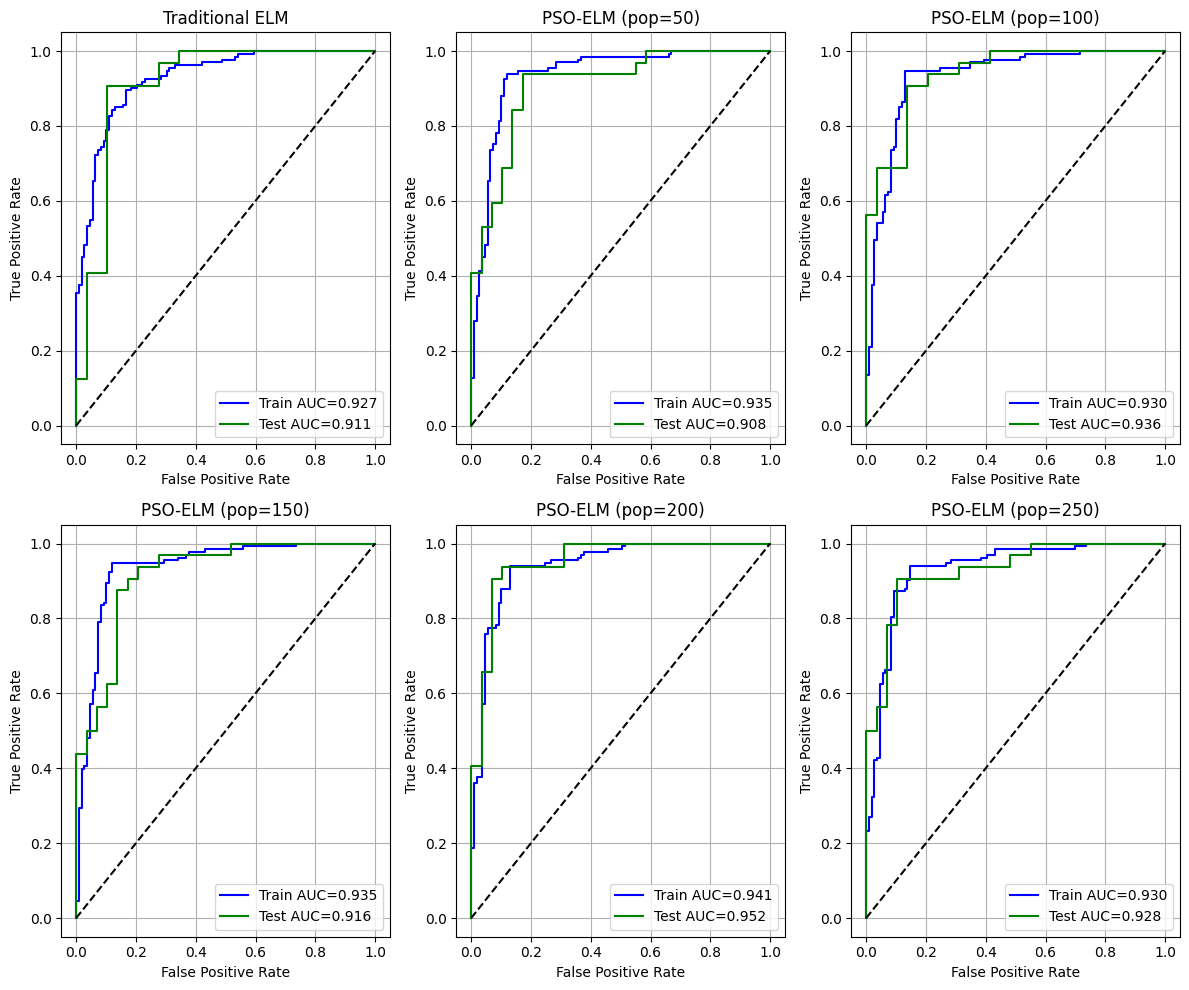

In [28]:
# ------------------------------------------------------------
# 8. Plot ROC Curves (2x3) for all cases - Train & Test in same subplot
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))
case_idx = 1
for model_name, data in predictions.items():
    y_train_true, y_train_pred, y_train_prob = data["train"]
    y_test_true, y_test_pred, y_test_prob = data["test"]

    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_prob)

    auc_train = roc_auc_score(y_train_true, y_train_prob)
    auc_test = roc_auc_score(y_test_true, y_test_prob)

    plt.subplot(2, 3, case_idx)
    plt.plot(fpr_train, tpr_train, label=f"Train AUC={auc_train:.3f}", color='blue')
    plt.plot(fpr_test, tpr_test, label=f"Test AUC={auc_test:.3f}", color='green')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    case_idx += 1

plt.tight_layout()
plt.savefig("ROC_all.png", dpi=300)
plt.show()

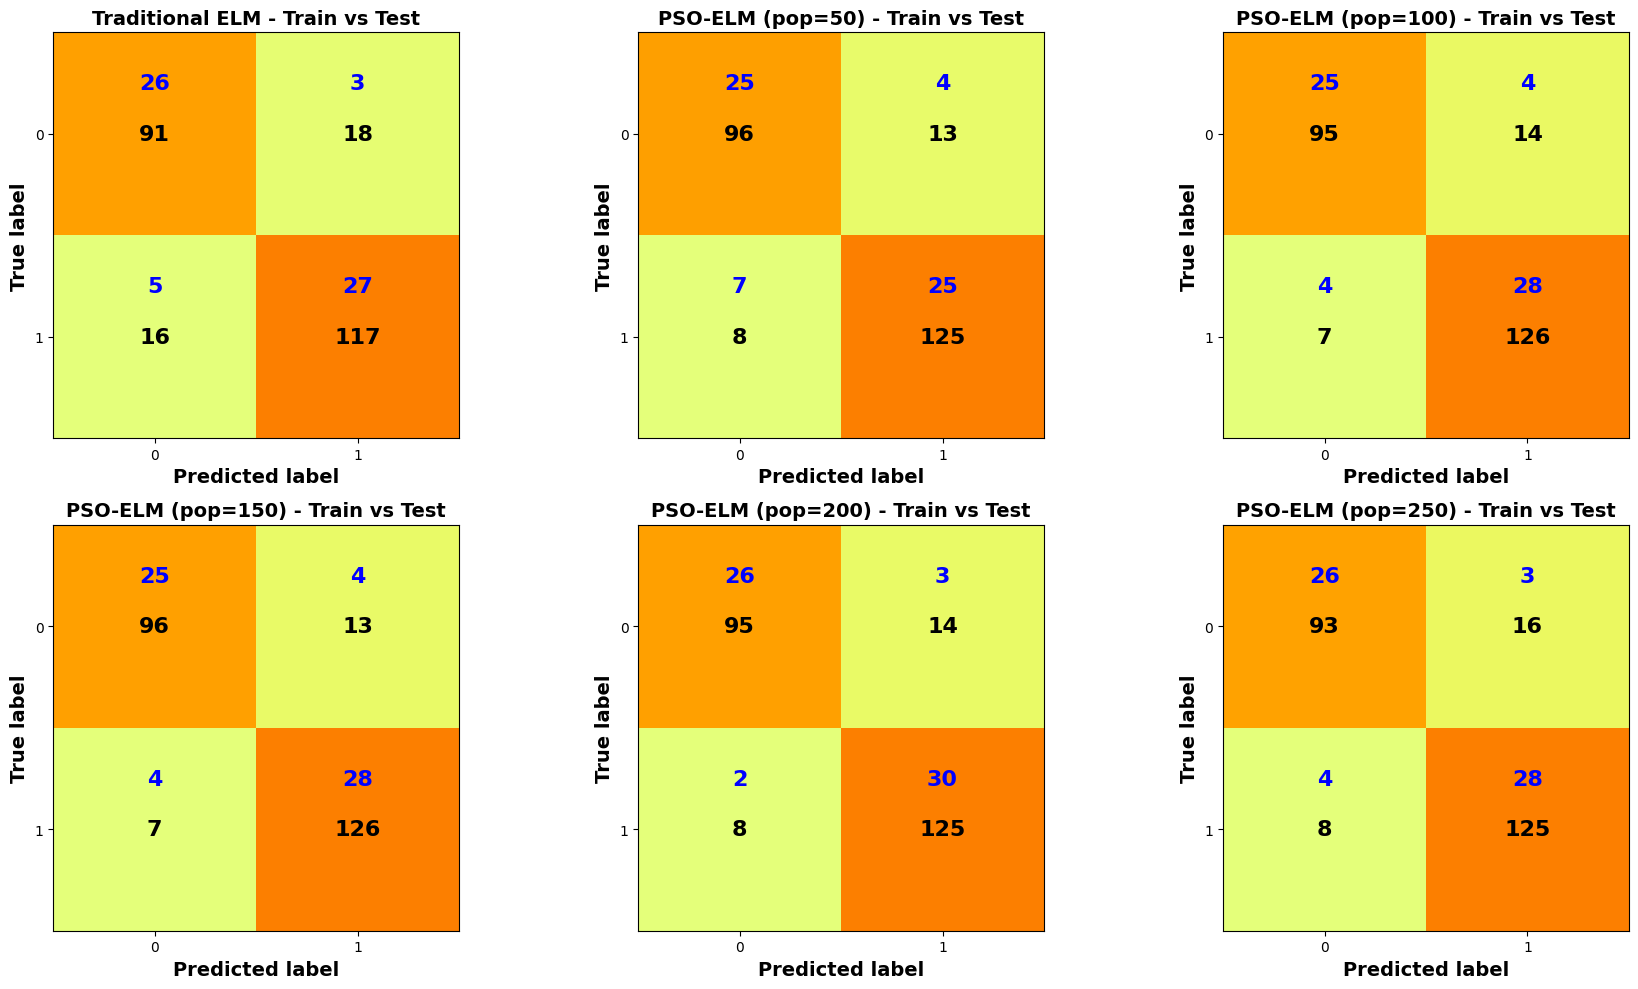

In [40]:
# ------------------------------------------------------------
# 9. Plot Confusion Matrices (train & test in same subplot) - clean
# ------------------------------------------------------------
plt.figure(figsize=(18, 10))
case_idx = 1
for model_name, data in predictions.items():
    y_train_true, y_train_pred, _ = data["train"]
    y_test_true, y_test_pred, _ = data["test"]

    cm_train = confusion_matrix(y_train_true, y_train_pred)
    cm_test = confusion_matrix(y_test_true, y_test_pred)

    plt.subplot(2, 3, case_idx)

    # Plot heatmap based on training CM
    plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(f"{model_name} - Train vs Test", fontsize=14, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
    plt.ylabel('True label', fontsize=14, fontweight='bold')

    # Tick marks
    tick_marks = np.arange(cm_train.shape[0])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)

    # Overlay numbers: train in black, test in red above
    for i in range(cm_train.shape[0]):
        for j in range(cm_train.shape[1]):
            plt.text(j, i, f"{cm_train[i, j]}", ha='center', va='center',
                     color='black', fontsize=16, fontweight='bold')
            plt.text(j, i - 0.25, f"{cm_test[i, j]}", ha='center', va='center',
                     color='blue', fontsize=16, fontweight='bold')

    case_idx += 1

plt.tight_layout()
plt.savefig("Confusion_Matrices_all.png", dpi=300)
plt.show()


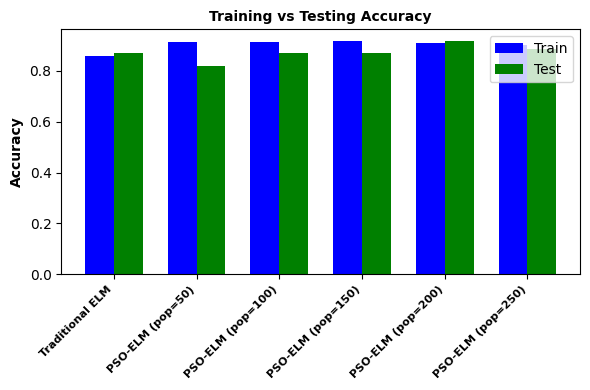

In [38]:
# ------------------------------------------------------------
# 10. Plot Training vs Testing Accuracy (Bar Chart)
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
train_acc = df_results[df_results["Dataset"]=="Train"]["Accuracy"]
test_acc = df_results[df_results["Dataset"]=="Test"]["Accuracy"]
models = df_results[df_results["Dataset"]=="Train"]["Model"]

x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_acc, width, label="Train", color="blue")
plt.bar(x + width/2, test_acc, width, label="Test", color="green")
plt.xticks(x, models, rotation=45, ha="right", fontsize=9, fontweight='bold')
plt.ylabel("Accuracy", fontsize=10, fontweight='bold')
plt.title("Training vs Testing Accuracy",  fontsize=10, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.savefig("Accuracy_all.png", dpi=300)
plt.show()
